# Navier-Stokes

In [1]:
"""
FEniCS tutorial demo program: Incompressible Navier-Stokes equations
for channel flow (Poisseuille) on the unit square using the
Incremental Pressure Correction Scheme (IPCS).

  u' + u . nabla(u)) - div(sigma(u, p)) = f
                                 div(u) = 0
"""

"\nFEniCS tutorial demo program: Incompressible Navier-Stokes equations\nfor channel flow (Poisseuille) on the unit square using the\nIncremental Pressure Correction Scheme (IPCS).\n\n  u' + u . nabla(u)) - div(sigma(u, p)) = f\n                                 div(u) = 0\n"

In [2]:
from __future__ import print_function
from fenics import *
import numpy as np

In [3]:
T = 10.0           # final time
num_steps = 500    # number of time steps
dt = T / num_steps # time step size
mu = 1             # kinematic viscosity
rho = 1            # density

Calling FFC just-in-time (JIT) compiler, this may take some time.


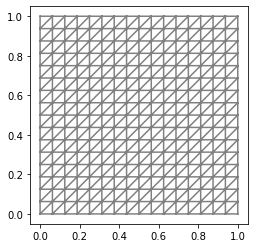

In [4]:
# Create mesh and define function spaces
mesh = UnitSquareMesh(16, 16)
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)
plot(mesh)

Para el ejemplo actual, estableceremos tres condiciones de contorno diferentes. Primero, estableceremos $u = 0$ en las paredes del canal; es decir, en $y = 0$ e $y = 1$. En segundo lugar, estableceremos $p=8$ en la entrada ($x=0$) y, finalmente, $p=0$ en la salida ($x = 1$). Esto dará como resultado un gradiente de presión que acelerará el flujo desde el estado inicial con velocidad cero. Estas condiciones de contorno se pueden definir de la siguiente manera:

In [5]:
# Define boundaries
inflow  = 'near(x[0], 0)'
outflow = 'near(x[0], 1)'
walls   = 'near(x[1], 0) || near(x[1], 1)'

# Define boundary conditions
bcu_noslip  = DirichletBC(V, Constant((0, 0)), walls)
bcp_inflow  = DirichletBC(Q, Constant(8), inflow)
bcp_outflow = DirichletBC(Q, Constant(0), outflow)
bcu = [bcu_noslip]
bcp = [bcp_inflow, bcp_outflow]

In [6]:
# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

In [7]:
# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

In [8]:
# Define expressions used in variational forms
U   = 0.5*(u_n + u)
n   = FacetNormal(mesh)
f   = Constant((0, 0))
k   = Constant(dt)
mu  = Constant(mu)
rho = Constant(rho)

In [9]:
# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

In [10]:
# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx + \
     rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

In [11]:
# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

In [12]:
# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

In [13]:
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [14]:
# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

[None, None]

t = 0.02: error = 0.84
max u: 0.16000000000000342
t = 0.04: error = 0.684
max u: 0.31568816144455875
t = 0.06: error = 0.548
max u: 0.45196701833303393
t = 0.08: error = 0.444
max u: 0.5559329370127628
t = 0.10: error = 0.365
max u: 0.6348216978885606
t = 0.12: error = 0.3
max u: 0.7004586647377167
t = 0.14: error = 0.246
max u: 0.754470057841082
t = 0.16: error = 0.202
max u: 0.7984010777240691
t = 0.18: error = 0.165
max u: 0.8347367548032284
t = 0.20: error = 0.136
max u: 0.864370379847623
t = 0.22: error = 0.111
max u: 0.8887571330649249
t = 0.24: error = 0.0913
max u: 0.908746179289391
t = 0.26: error = 0.0749
max u: 0.9251289439389165
t = 0.28: error = 0.0614
max u: 0.9385959080817934
t = 0.30: error = 0.0504
max u: 0.9496145471152563
t = 0.32: error = 0.0413
max u: 0.958678413638838
t = 0.34: error = 0.0339
max u: 0.9660952072888659
t = 0.36: error = 0.0278
max u: 0.9721919158198927
t = 0.38: error = 0.0228
max u: 0.9771864377335554
t = 0.40: error = 0.0187
max u: 0.981286118545

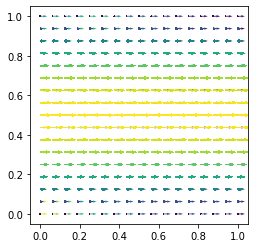

In [17]:
# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    # Plot solution
    plot(u_)
    
    # Compute error
    u_e = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
    u_e = interpolate(u_e, V)
    error = np.abs(u_e.vector().get_local() - u_.vector().get_local()).max()
    print('t = %.2f: error = %.3g' % (t, error))
    print('max u:', u_.vector().get_local().max())

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)

In [18]:
###################################################################

In [19]:
"""
FEniCS tutorial demo program: Incompressible Navier-Stokes equations
for flow around a cylinder using the Incremental Pressure Correction
Scheme (IPCS).

  u' + u . nabla(u)) - div(sigma(u, p)) = f
                                 div(u) = 0
"""

"\nFEniCS tutorial demo program: Incompressible Navier-Stokes equations\nfor flow around a cylinder using the Incremental Pressure Correction\nScheme (IPCS).\n\n  u' + u . nabla(u)) - div(sigma(u, p)) = f\n                                 div(u) = 0\n"

In [20]:
from __future__ import print_function
from fenics import *
from mshr import *
import numpy as np

In [21]:
T = 5.0            # final time
num_steps = 5000   # number of time steps
dt = T / num_steps # time step size
mu = 0.001         # dynamic viscosity
rho = 1            # density

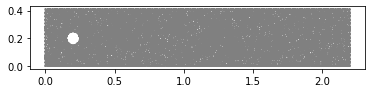

In [25]:
# Create mesh
channel = Rectangle(Point(0, 0), Point(2.2, 0.41))
cylinder = Circle(Point(0.2, 0.2), 0.05)
domain = channel - cylinder
mesh = generate_mesh(domain, 64)
plot(mesh)

In [26]:
# Define function spaces
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

In [27]:
# Define boundaries
inflow   = 'near(x[0], 0)'
outflow  = 'near(x[0], 2.2)'
walls    = 'near(x[1], 0) || near(x[1], 0.41)'
cylinder = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'

In [28]:
# Define inflow profile
inflow_profile = ('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0')

In [29]:
# Define boundary conditions
bcu_inflow = DirichletBC(V, Expression(inflow_profile, degree=2), inflow)
bcu_walls = DirichletBC(V, Constant((0, 0)), walls)
bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)
bcp_outflow = DirichletBC(Q, Constant(0), outflow)
bcu = [bcu_inflow, bcu_walls, bcu_cylinder]
bcp = [bcp_outflow]

In [30]:
# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

In [31]:
# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

In [32]:
# Define expressions used in variational forms
U  = 0.5*(u_n + u)
n  = FacetNormal(mesh)
f  = Constant((0, 0))
k  = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)

In [33]:
# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

In [34]:
# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx \
   + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

In [35]:
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

[None]

In [ ]:
# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1, 'bicgstab', 'hypre_amg')

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2, 'bicgstab', 'hypre_amg')

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3, 'cg', 'sor')

    # Plot solution
    plot(u_, title='Velocity')
    plot(p_, title='Pressure')
    
    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)